# Empirical guarantees: a series

In [305]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from pyselect.datasets import make_gregorova_se1, make_gregorova_se2, make_jordan_se1
from pyselect.model import RFFNet, RFFLayer

In [776]:
seed = 0

In [777]:
rng = np.random.RandomState(0)
torch.manual_seed(seed)

## Data

In [778]:
n_samples = 6*10**3
n_features = 18

In [779]:
train_size = 5*10**3

In [780]:
X, y = make_gregorova_se1(n_samples=n_samples, random_state=seed)

In [781]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)

In [894]:
from sklearn.preprocessing import StandardScaler

In [895]:
scaler = StandardScaler()

In [896]:
X_train = scaler.fit_transform(X_train)

In [897]:
X_val = scaler.transform(X_val)

In [898]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

## Model

In [899]:
n_random_features = int(np.sqrt(train_size) * np.log(train_size))

# Aspects to explore

## Solvers

Testing solvers
* SAPALM: with Adam
    * Mini batches
* SAPALM: with SGD
* SGD: all parameters

Conditions
* Without early stopping.
* With $\ell_2$ regularization.

In [900]:
n_epochs = 100
lr = 1e-2
batch_size = 500
alpha = 0
log_rate = 5

In [901]:
criterion = torch.nn.MSELoss()

In [902]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)

### SAPALMs

#### SAPALM (Adam)

In [903]:
torch.manual_seed(seed)

In [904]:
model = RFFNet(dims=[n_features, n_random_features, 1])

In [905]:
optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

In [906]:
adam_history = []
for epoch in range(n_epochs):
    indices = torch.randperm(train_size)
    model.train()
    
    for i in range(train_size // batch_size):
        batch = indices[i * batch_size: (i+1) * batch_size]
        pred = model(X_train[batch])
        
        loss = criterion(pred, y_train[batch])
        
        optim_linear.zero_grad()
        loss.backward()
        optim_linear.step()
        
        # with torch.no_grad():
        #     curr_lr = optim_linear.param_groups[0]["lr"]
        #     model.linear.weight.data = prox_2_squared(
        #         model.linear.weight.data, alpha * curr_lr
        #     )
            
    for i in range(train_size // batch_size):
        batch = indices[i * batch_size: (i+1) * batch_size]
        pred = model(X_train[batch])
        
        loss = criterion(pred, y_train[batch])
        
        optim_rff.zero_grad()
        loss.backward()
        optim_rff.step()
    
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val)
        adam_history.append(val_loss)    

In [907]:
model_adam = model.state_dict()

#### SAPALM (SGD)

In [141]:
torch.manual_seed(seed)

In [142]:
model = RFFNet(dims=[n_features, n_random_features, 1])

In [143]:
optim_linear = torch.optim.SGD(model.linear.parameters(), lr=lr)
optim_rff = torch.optim.SGD(model.rff.parameters(),lr=lr)

In [144]:
sgd_history = []
for epoch in range(n_epochs):
    indices = torch.randperm(train_size)
    model.train()
    
    for i in range(train_size // batch_size):
        batch = indices[i * batch_size: (i+1) * batch_size]
        pred = model(X_train[batch])
        
        loss = criterion(pred, y_train[batch])
        
        optim_linear.zero_grad()
        loss.backward()
        optim_linear.step()
        
        with torch.no_grad():
            curr_lr = optim_linear.param_groups[0]["lr"]
            model.linear.weight.data = prox_2_squared(
                model.linear.weight.data, alpha * curr_lr
            )
            
    for i in range(train_size // batch_size):
        batch = indices[i * batch_size: (i+1) * batch_size]
        pred = model(X_train[batch])
        
        loss = criterion(pred, y_train[batch])
        
        optim_rff.zero_grad()
        loss.backward()
        optim_rff.step()
    
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val)
        sgd_history.append(val_loss)    

In [145]:
model_sgd = model.state_dict()

### SGD

In [146]:
torch.manual_seed(seed)

In [147]:
model = RFFNet(dims=[n_features, n_random_features*2, 1])

In [148]:
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=2 * alpha)

In [149]:
sgd2_history = []
for epoch in range(n_epochs):
    indices = torch.randperm(train_size)
    model.train()
    
    for i in range(train_size // batch_size):
        batch = indices[i * batch_size: (i+1) * batch_size]
        pred = model(X_train[batch])
        
        loss = criterion(pred, y_train[batch])
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    ada
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val)
        sgd2_history.append(val_loss)    

In [150]:
model_sgd2 = model.state_dict()

### Comparing

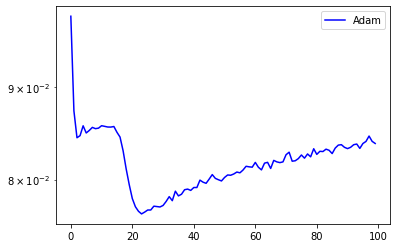

In [908]:
#plt.plot(sgd_history, color='red', label="SGD")
plt.plot(adam_history, color='blue', label="Adam")
#plt.plot(sgd2_history, color='orange', label="SGD 2")
plt.yscale('log')
plt.legend()
plt.show()

<StemContainer object of 3 artists>

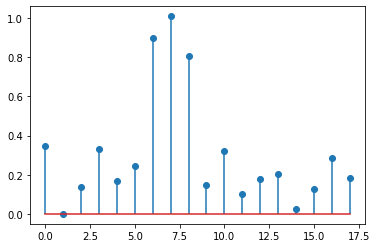

In [909]:
plt.stem(np.abs(model_adam['rff.precisions'].detach().numpy()))

Decision: keep PALM with Adam, but tuning is indisputably needed.

---

## Batch influence

In [245]:
n_epochs = 100
lr = 1e-3
batch_size = 32
alpha = 0.0
log_rate = 5

In [246]:
def train(batch_size, lr):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)    
        
    return adam_history, model.state_dict()

In [250]:
histories = []
state_dicts = []

In [251]:
for lr, batch_size in zip([1e-3, 1e-3, 1e-3, 1e-2, 1e-2], [10, 32, 100, 200, 500]):
    hist, state_dict = train(batch_size, lr)
    histories.append(hist)
    state_dicts.append(state_dict)

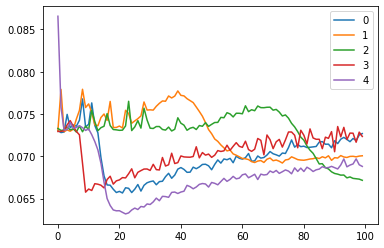

In [252]:
for i, hist in enumerate(histories):
    plt.plot(hist, label=i)
plt.legend()
plt.show()

Decision: high batch sizes are indeed trainable. Does it generalize to other datasets?

---

## Early stopping vs. regularization

Scenarios:
* Decreasing regularization and the validation loss.


In [70]:
n_epochs = 200
lr = 1e-2
batch_size = 500
log_rate = 5

In [71]:
def train2(alpha):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)    
        
    return adam_history, model.state_dict()

In [74]:
histories = []
state_dicts = []

In [75]:
for alpha in [0.0, *np.linspace(0.01, 3, 10)]:
    print(alpha)
    hist, state_dict = train2(alpha)
    histories.append(hist)
    state_dicts.append(state_dict)

0.0
0.01
0.34222222222222226
0.6744444444444445
1.0066666666666668
1.338888888888889
1.6711111111111112
2.0033333333333334
2.3355555555555556
2.667777777777778
3.0


<StemContainer object of 3 artists>

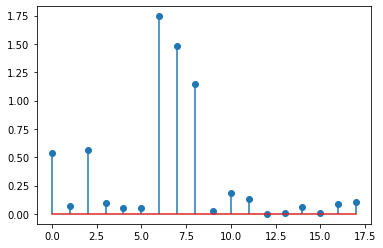

In [76]:
plt.stem(np.abs(state_dicts[7]['rff.precisions']))

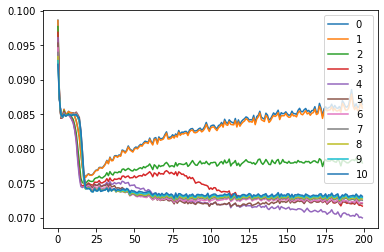

In [79]:
for i, hist in enumerate(histories):
    plt.plot(hist, label=i)
plt.legend()
#plt.ylim(0.06, 0.075)
plt.show()

Decision: remove regularization, as it does have some impact, but this impact is minor when compared to the need of tuning.

## Is there double descent?

In [195]:
n_epochs = 200
lr = 1e-2
batch_size = 500
log_rate = 5

In [196]:
def train2(alpha):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    train_history = []
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            loss = criterion(model(X_train), y_train)
            adam_history.append(val_loss) 
            train_history.append(loss)
        
    return train_history, adam_history, model.state_dict()

In [197]:
train_hist =  []
histories = []
state_dicts = []

In [198]:
for alpha in [0.0, *np.linspace(0.01, 3, 10)]:
    print(alpha)
    train, hist, state_dict = train2(alpha)
    train_hist.append(train)
    histories.append(hist)
    state_dicts.append(state_dict)

0.0
0.01
0.34222222222222226
0.6744444444444445
1.0066666666666668
1.338888888888889
1.6711111111111112
2.0033333333333334
2.3355555555555556
2.667777777777778
3.0


<StemContainer object of 3 artists>

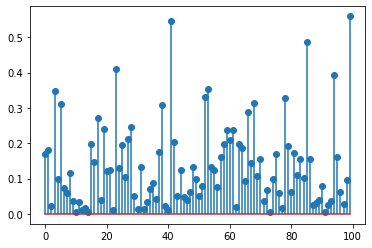

In [199]:
plt.stem(np.abs(state_dicts[7]['rff.precisions']))

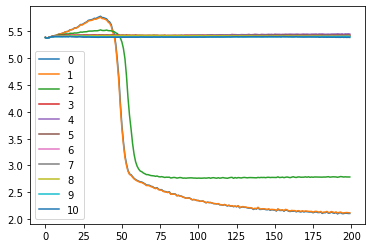

In [206]:
for i, hist in enumerate(histories):
    plt.plot(hist, label=i)
plt.legend()
#plt.ylim(0.072, 0.077)
#plt.xlim(10, 50)
plt.show()

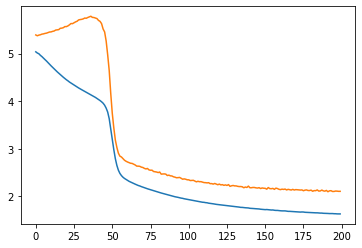

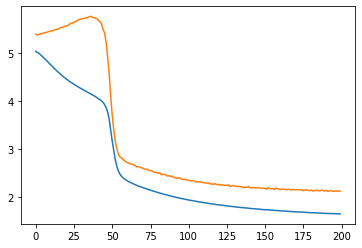

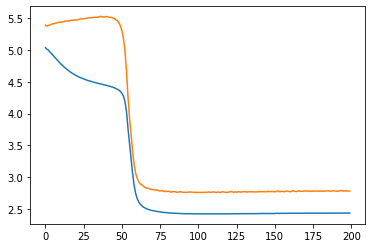

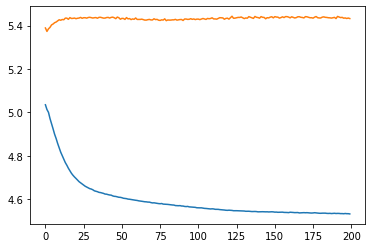

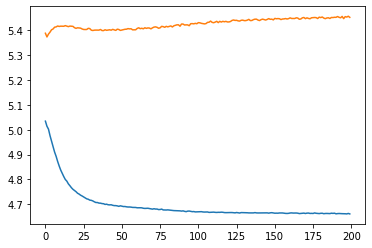

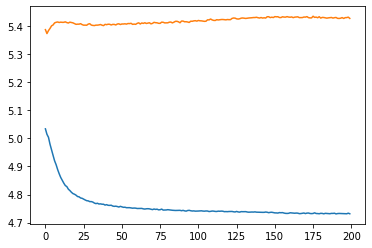

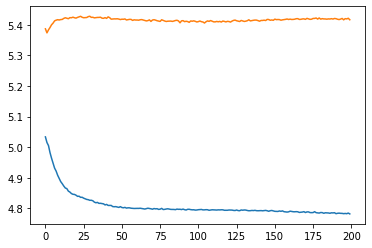

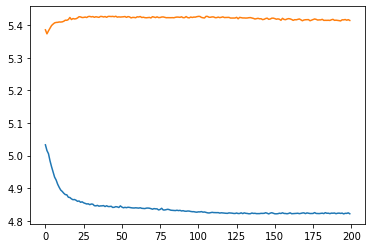

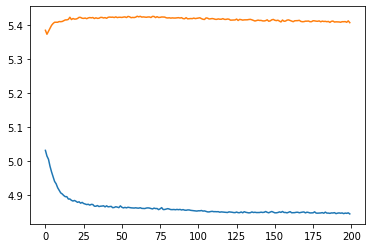

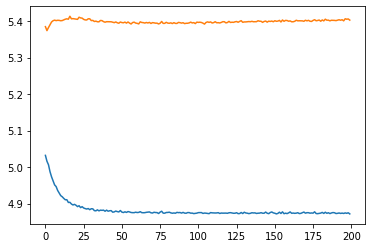

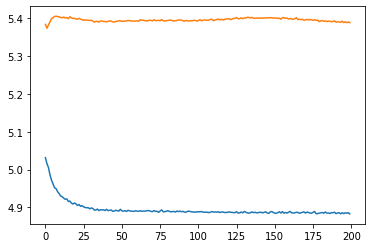

In [201]:
for i in range(11):
    plt.figure()
    plt.plot(np.arange(200), train_hist[i], histories[i], label=i)
#plt.ylim(0.06, 0.075)
plt.show()

Decision: remove $\ell^2$ regularization.

---

## Initialization

* Bandwidth initialization
* Linear weight initialization (see https://openreview.net/pdf?id=Sks3zF9eg)

In [202]:
from typing import Callable

import torch.nn as nn
from torch import Tensor

In [216]:
class RFFLayer(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        sampler: Callable[[int, int], Tensor] = torch.randn,
    ):
        """Constructor of Random Fourier Features Layer."""
        super(RFFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Parameters
        self.precisions = nn.Parameter(torch.empty(in_features))

        # Buffers
        self.register_buffer(
            "_omega_sample",
            sampler(self.in_features, self.out_features),
            persistent=True,
        )
        self.register_buffer(
            "_unif_sample",
            torch.rand(self.out_features) * 2 * np.pi,
            persistent=True,
        )
        self.reset_parameters()

    def forward(self, x):
        # normalizing factor
        norm = torch.tensor(2.0 / self.out_features)
        output = torch.sqrt(norm) * torch.cos(
            (x * self.precisions) @ self._omega_sample + self._unif_sample
        )

        return output

    def reset_parameters(self, val=0.0):
        nn.init.constant_(self.precisions, val)

    def __repr__(self):
        return f"RFFLayer(in_features={self.in_features}, out_features={self.out_features})"

In [217]:
class RFFNet(nn.Module):
    def __init__(self, dims, sampler=torch.randn):
        """Constructor of the Random Fourier Features Network."""
        super(RFFNet, self).__init__()

        self.rff = RFFLayer(dims[0], dims[1], sampler)
        self.linear = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, x):
        """Perform a forward pass on the complete network."""
        random_features = self.rff(x)
        return self.linear(random_features)
    
    def reset_parameters(self, strategy, disp=np.sqrt(5)):
        if strategy == "kaiming":
            nn.init.kaiming_uniform_(self.linear.weight, a=disp)
        if strategy == "normal":
            nn.init.normal_(self.linear.weight, std=disp)
        if strategy == "xavier":
            nn.init.xavier_uniform_(self.linear.weight, gain=disp)     

    def cpu_state_dict(self):
        return {k: v.detach().clone().cpu() for k, v in self.state_dict().items()}

    def get_precisions(self):
        return self.rff.precisions.detach().cpu().numpy()

In [218]:
n_epochs = 200
lr = 1e-2
batch_size = 500
log_rate = 5

In [233]:
def train2(strategy, disp):
    alpha = 0
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    model.reset_parameters(strategy, disp)
    
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    train_history = []
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            loss = criterion(model(X_train), y_train)
            adam_history.append(val_loss) 
            train_history.append(loss)
        
    return train_history, adam_history, model.state_dict()

In [237]:
train_hist =  []
histories = []
state_dicts = []

In [238]:
for s in ["kaiming", "normal", "xavier"]:
    for disp in [1e-2, 1e-1, 1, np.sqrt(5), 4]:
        ht, hv, sd = train2(s, disp)
        train_hist.append(ht)
        histories.append(hv)
        state_dicts.append(sd)
        

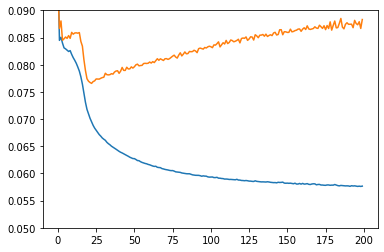

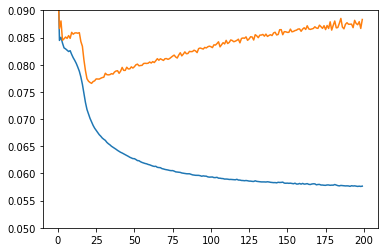

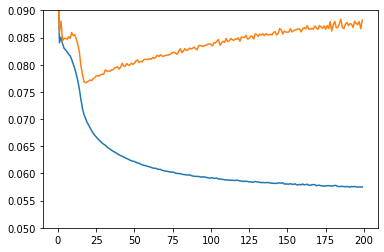

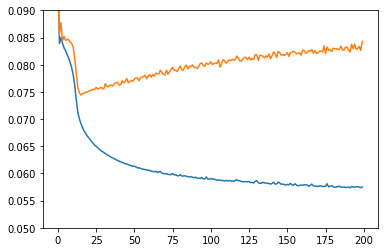

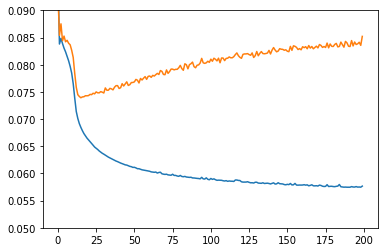

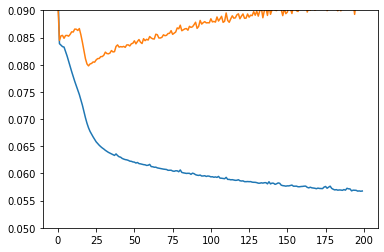

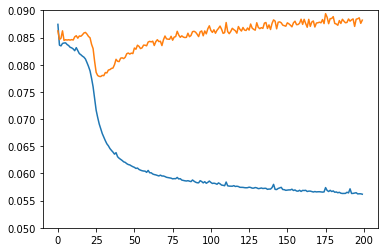

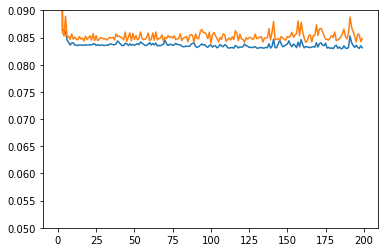

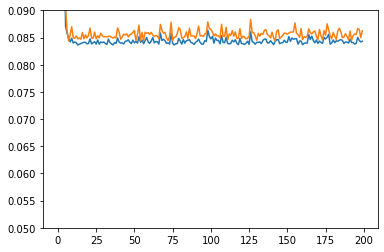

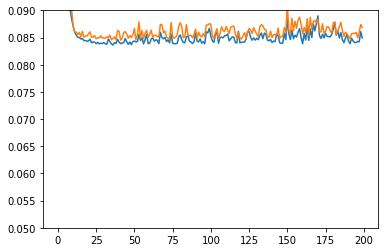

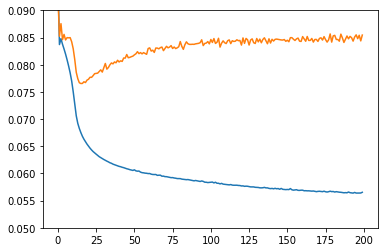

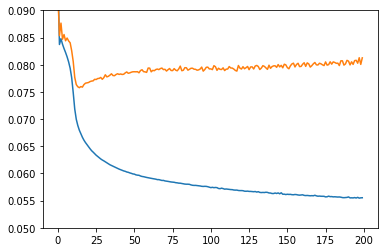

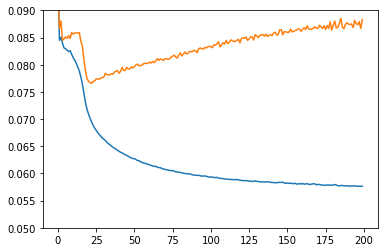

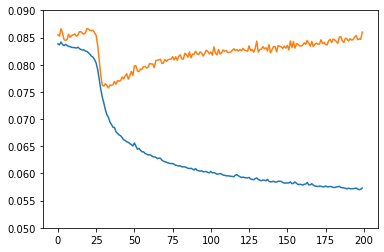

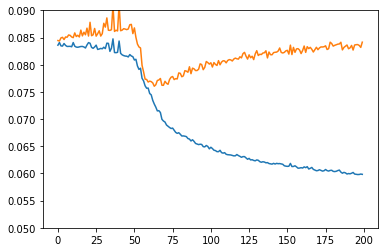

In [246]:
for i in range(len(train_hist)):
    plt.figure()
    plt.plot(np.arange(200), train_hist[i], histories[i], label=i)
    plt.ylim(0.05, 0.09)
plt.show()

---

## Empirical kernel 

In [307]:
n_epochs = 50
lr = 1e-2
batch_size = 500
log_rate = 5

In [308]:
def train2():
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    kernel_history = []
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss) 
            if epoch % 5 == 0:
                random_features = model.rff(X_train)
                kernel_matrix = random_features.T @ random_features
                kernel_history.append(kernel_matrix)
        
    return kernel_history, adam_history, model.state_dict()

In [171]:
seed = 0

In [172]:
rng = np.random.RandomState(0)
torch.manual_seed(seed)

## Data

In [227]:
n_samples = 6*10**3
n_features = 18

In [228]:
train_size = 5*10**3

In [229]:
X, y = make_gregorova_se1(n_samples=n_samples, random_state=seed)

In [230]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)

In [231]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

In [309]:
a, b, c = train2()

In [352]:
eigenvalues = []

In [353]:
for m in a:
    eigen = np.linalg.eigvals(m.numpy())
    eigenvalues.append(np.sort(eigen)[::-1][:20])

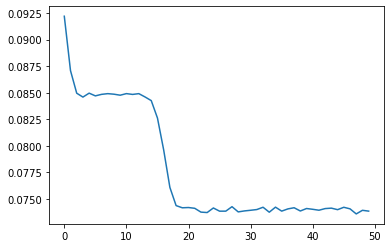

In [354]:
plt.figure()
plt.plot(np.arange(50), b)
plt.show()

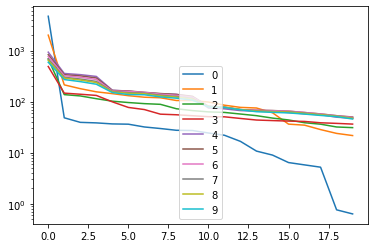

In [355]:
for i, eig in enumerate(eigenvalues):
    plt.plot(eig.real, label=i)
plt.legend()
#plt.ylim(10, 100)
plt.yscale('log')

---

## Oracles in controlled situations

Knowing the regression function, obtain bounds on the error as training proceeds.

In [356]:
seed = 0

In [357]:
rng = np.random.RandomState(0)
torch.manual_seed(seed)

## Data

In [418]:
n_samples = 6*10**3
n_features = 1000

In [419]:
train_size = 5*10**3

In [420]:
X, y = make_jordan_se1(n_samples=n_samples, n_features=1000,
                       random_state=seed)

In [421]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)

In [422]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

In [423]:
n_epochs = 50
lr = 1e-2
batch_size = 500
log_rate = 5

In [424]:
X_val[:,0].size()

torch.Size([1000])

In [425]:
def train2():
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)
    
    oracle_history = []
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, alpha * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            oracle_history.append(criterion(model(X_val), torch.reshape(X_val[:, 0],  (1000,1))))
            adam_history.append(val_loss)
            
    return oracle_history, adam_history, model.state_dict()

In [426]:
a, b, c = train2()

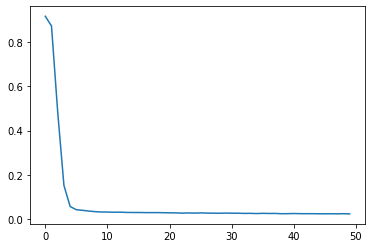

In [427]:
plt.plot(a)

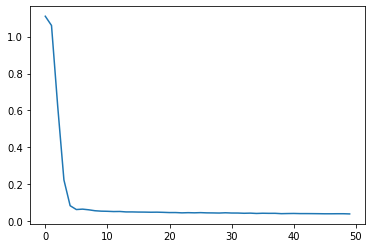

In [428]:
plt.plot(b)

---

## Number of features 

In [757]:
n_epochs = 30
lr = 1e-2
batch_size = 500
log_rate = 5

In [758]:
def train2(n_random_features):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)
            
    return adam_history, model.state_dict()

In [759]:
critical = np.floor(np.sqrt(train_size) * np.log(train_size)).astype(np.int32)

In [760]:
features = np.arange(20, 1000, 50)

In [761]:
histories =  []
models = []

In [762]:
for f in [*features, critical]:
    h, m = train2(f)
    histories.append(h)
    models.append(m)

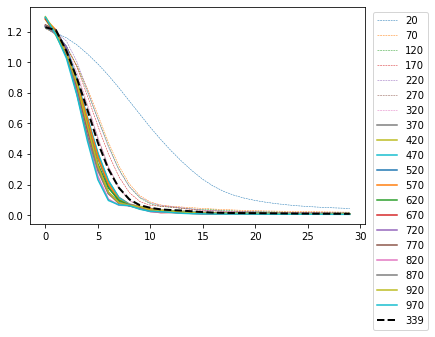

In [770]:
for i, h in enumerate(histories[:-1]):
    if features[i] <= critical:
        plt.plot(h,  '--', lw=0.5, label=features[i])
    else:
        plt.plot(h,  '-', label=features[i])
plt.plot(histories[-1], '--', color='k', lw=2, label=critical)
plt.legend(bbox_to_anchor=(1.01, 1))
#plt.ylim(0.025, 0.05)
#plt.xlim(8, 18)
plt.show()

---

## Samplers

In [236]:
n_epochs = 200
lr = 1e-2
batch_size = 500
log_rate = 5

In [237]:
def train2(sampler):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1], sampler=sampler)
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)
            
    return adam_history, model.state_dict()

In [238]:
samplers = [
    torch.randn,
    lambda x, y: Cauchy(0, 1).sample(sample_shape=(x, y)),
    lambda x, y: Laplace(0, 1).sample(sample_shape=(x, y)),
]

In [239]:
histories =  []
models = []

In [240]:
for s in samplers:
    h, m = train2(s)
    histories.append(h)
    models.append(m)

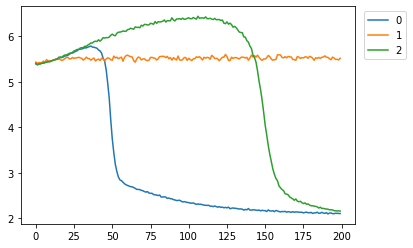

In [241]:
for i, h in enumerate(histories):
    plt.plot(h,  '-', label=i)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

---

# Early stopping

In [586]:
n_iter_no_change = 10

In [587]:
def train_final():
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])
    
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()

        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)
            
        if val_loss < best_val_loss:
            best_model_state_dict = model.state_dict()
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count == n_iter_no_change:
            
            break
          
    
    model.load_state_dict(best_model_state_dict)
    
    return adam_history, model.state_dict()

In [588]:
his, model = train_final()

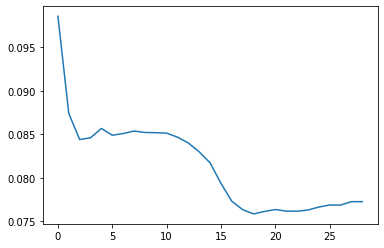

In [589]:
plt.plot(his)

<StemContainer object of 3 artists>

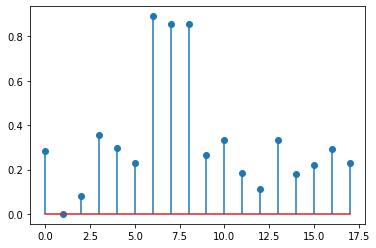

In [590]:
plt.stem(np.abs(model['rff.precisions']))

---

## $L_1$ penalization

In [910]:
n_iter_no_change = 10

In [911]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)

In [912]:
def ST_vec(x, u):
    """Entrywise soft-thresholding of array x at level u."""
    return np.sign(x) * np.maximum(0.0, np.abs(x) - u)

In [913]:
def ST(x, alpha):
    return torch.sign(x) * torch.maximum(torch.Tensor([0.0]), torch.abs(x) - alpha)

In [914]:
n_epochss = 100

In [915]:
def train_l1(alpha):
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])
    
    adam_history = []
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()
            
            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.rff.precisions.data = ST(
                    model.rff.precisions.data, alpha * curr_lr
                )
                
        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss)
            
        if val_loss < best_val_loss:
            best_model_state_dict = model.state_dict()
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count == n_iter_no_change:  
            break
          
    model.load_state_dict(best_model_state_dict)
    
    return adam_history, model.state_dict()

In [916]:
histories, models = [], [] 

In [917]:
for alpha in np.logspace(-2, 2, 20):
    his, model = train_l1(alpha)
    histories.append(his)
    models.append(model)

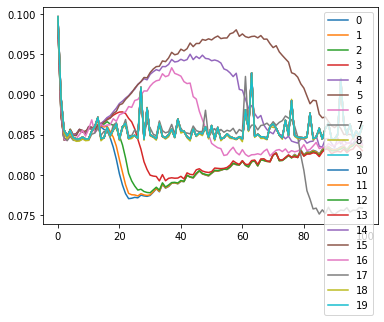

In [918]:
for i, his in enumerate(histories):
    plt.plot(his, label=i)
plt.legend()
plt.show()

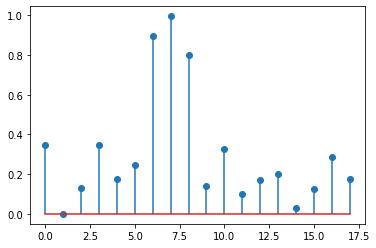

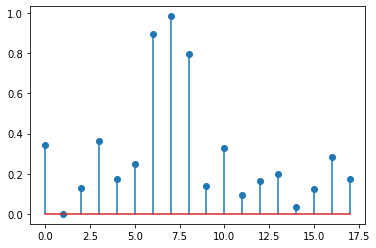

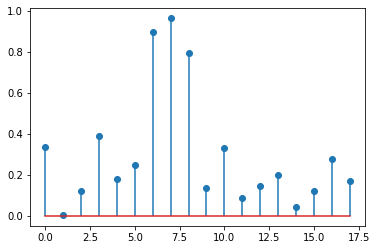

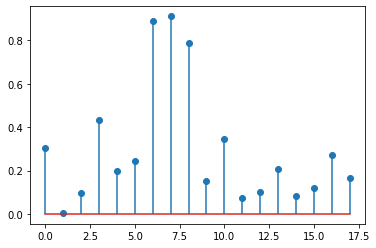

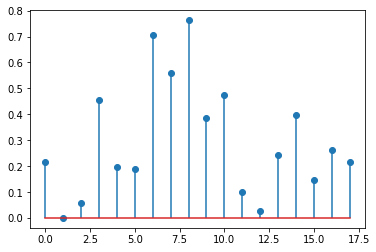

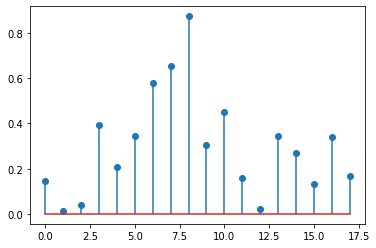

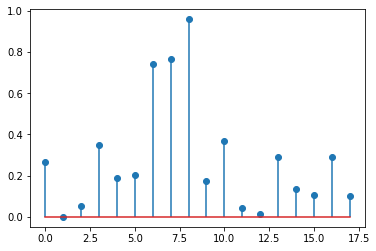

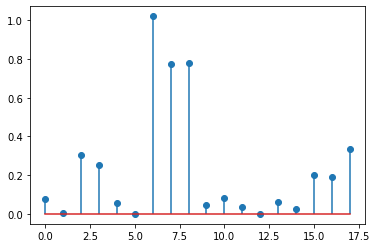

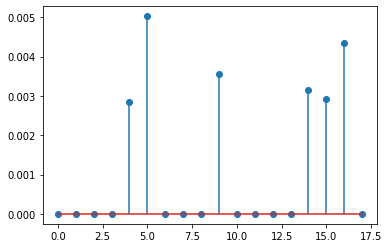

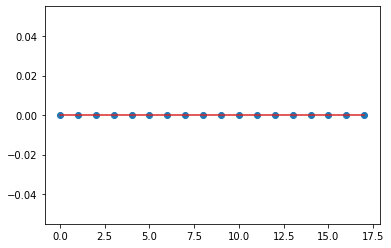

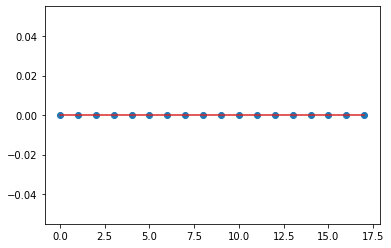

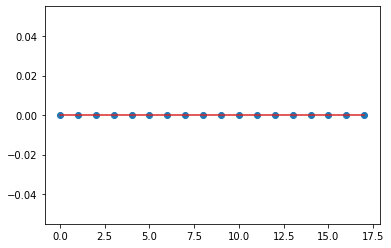

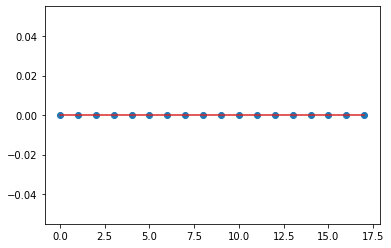

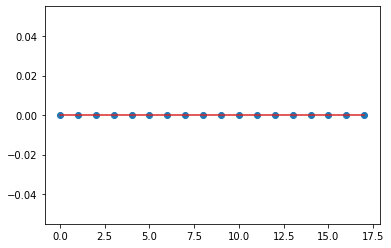

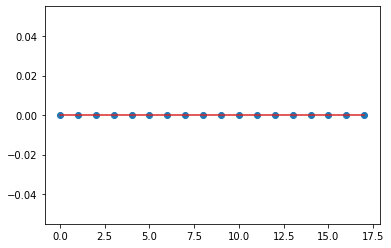

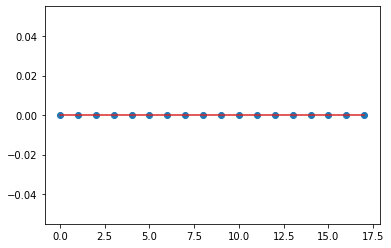

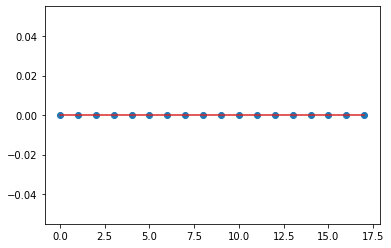

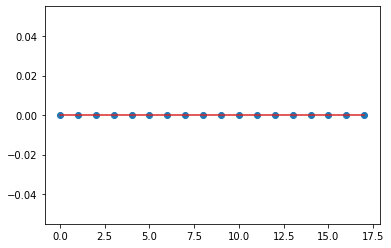

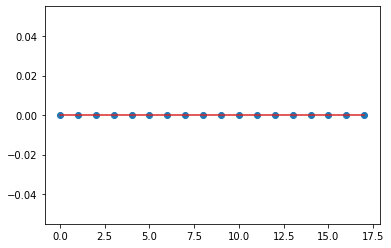

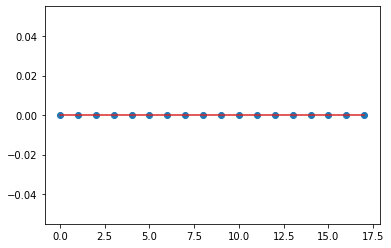

In [919]:
for i, model in enumerate(models):
    plt.figure()
    plt.stem(np.abs(model['rff.precisions']))
plt.show()
